In [1]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs
from database import select_dataset
from graphmodels.utils import get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic
import pandas as pd
import numpy as np
from models.Hermen.model_BE2 import BE2_models

In [2]:
fbs_data = select_dataset('foodbalancesheet')
population_data = select_dataset('population')
crops_data = select_dataset('crops')
landuse = select_dataset('landuse')

In [3]:
model_df = pd.concat([fbs_data, population_data, crops_data],).dropna(subset=['Variable'])
model_df = model_df[~model_df.Variable.isin(['Domestic supply quantity'])]

In [38]:
from graphmodels.utils import df_to_data_dict

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]
    return X


def fill_missing_values(df):
    return df


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    
    if itemized != []:
        item_df = df[df.Variable.isin(itemized)].pivot(
            index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
        data_dict.update(df_to_dict(item_df))


    data_dict.update(df_to_dict(non_item_df))

    return data_dict


itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
    ]

data_dict = df_to_data_dict(model_df, itemized)


data_dict.update(df_to_data_dict(landuse, itemized=[]))
data_dict['CL_baseline'] = data_dict['CL'] 
data_dict['IL_baseline'] = data_dict['IL'] 
data_dict['FL_baseline'] = data_dict['FL'] 
data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)


In [40]:
from graphmodels.utils import get_X_y_from_data
X, y_true = get_X_y_from_data(BE2_models['TCLDi_model'], data_dict)

score_model(BE2_models['TCLDi_model'], X, y_true)

FPi
TCLDi


,r2,correlation,rmse,Variable
0,1.000000,1.000000,3.333132e+01,FPi
1,0.993083,0.997947,3.083538e+11,TCLDi


In [41]:
X, y_true = get_X_y_from_data(BE2_models['IL_FL_model'], data_dict)

score_model(BE2_models['IL_FL_model'], X, y_true)

IL
FL


,r2,correlation,rmse,Variable
0,1.0,1.0,0.0,IL
1,1.0,1.0,0.0,FL


In [42]:
X, y_true = get_X_y_from_data(BE2_models['BE2_model'], data_dict)

score_model(BE2_models['BE2_model'], X, y_true)

FL
IL
CL
TCLDi
FPi


,r2,correlation,rmse,Variable
0,1.000000,1.000000,0.000000e+00,FL
1,-60.376810,0.825521,8.295169e+08,IL
2,-0.068482,0.267987,5.198099e+08,CL
3,0.993083,0.997947,3.083538e+11,TCLDi
4,1.000000,1.000000,3.333132e+01,FPi


In [43]:
res = BE2_models['BE2_model'].run(X)

In [44]:
res['TCLDi'].groupby(level=['ISO', 'Year']).sum()

ISO  Year
AFG  1961         0.000000
     1962         0.000000
     1963         0.000000
     1964         0.000000
     1965         0.000000
                 ...      
ZWE  2015    345850.174138
     2016    451517.423549
     2017    316234.217933
     2018    344889.576251
     2019         0.000000
Length: 10773, dtype: float64

In [45]:

'lalala_two'.rstrip('_one').rstrip('_two')

'lalala'

In [46]:
res = BE2_models['BE2_model'].run(X)

# Assumptions 

- FLOi: user input, 2050 target +50 -50% baseline 
- FDKGi: user input, 1st idea a 2050 target +50 -50% baseline, interpolate in between same for everygroup. (Maybe see how to do to diet change later)
- Pop: projection
- OFi children: keep constant (maybe a regression later to have something more relevant)
- FDi: for now incomplete (FCRi in complete model maybe play with it, FCRi scenario: to check for now leave alone !). 
- SSRi : could stay constant, could be projected with pop, some increase somehow, let's see case by case (Might need some sort feedbackloop with landuse)
- CYi : user input, 2050 target ! (to look for realistic values)
- TLA: constant
- R_rate: User input, 


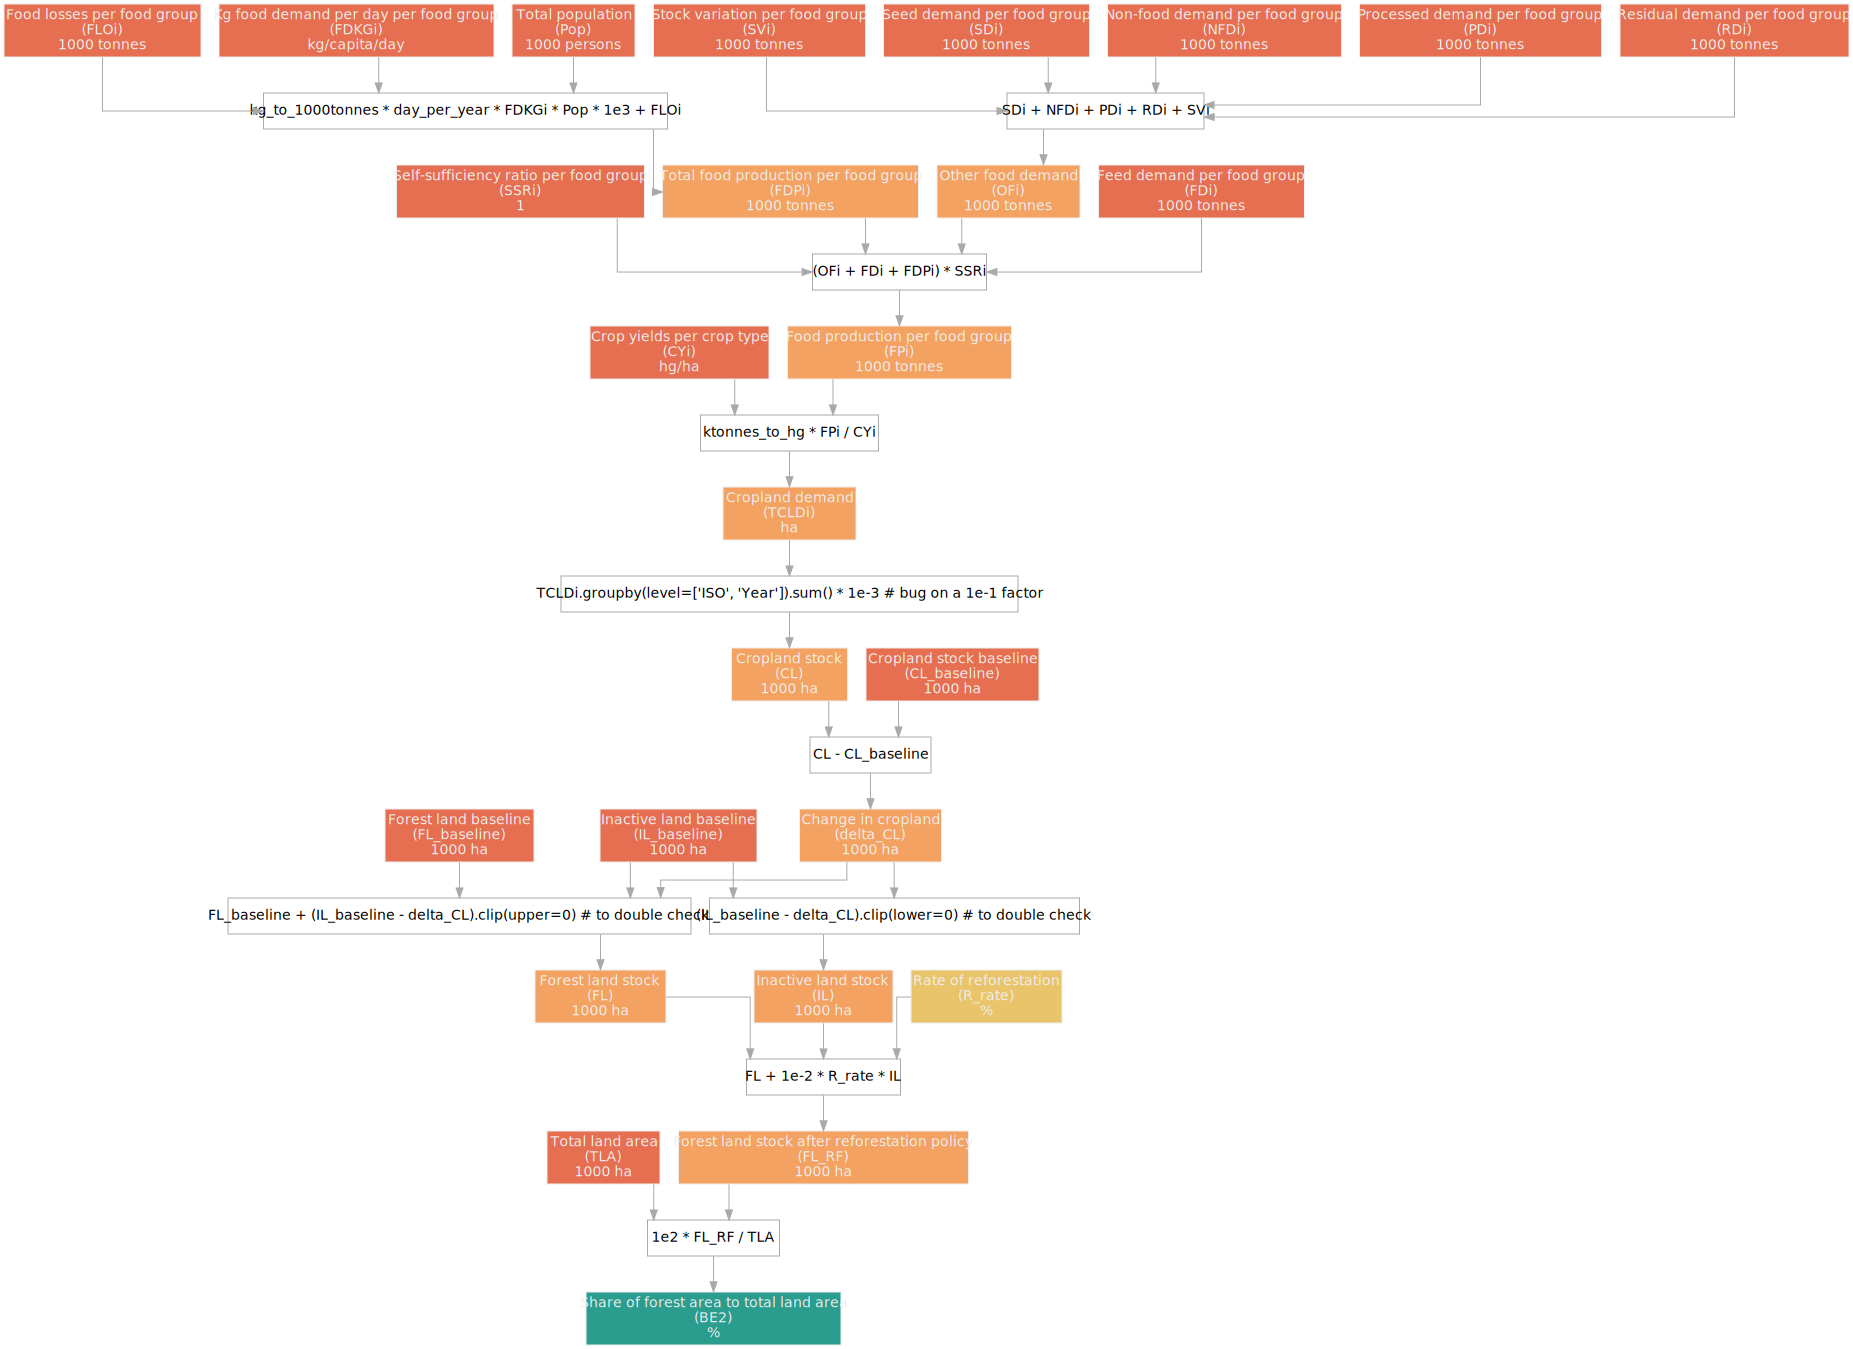

In [47]:
BE2_models['BE2_model'].draw()

In [48]:
data_dict.keys()

dict_keys(['CYi', 'FDKCi', 'FDKGi', 'FDi', 'FEi', 'FIi', 'FLOi', 'FPi', 'Food', 'KKRi', 'NFDi', 'PDi', 'RDi', 'SDi', 'SSRi', 'SVi', 'TCLDi', 'Pop', 'CL', 'FL', 'IL', 'TLA', 'CL_baseline', 'IL_baseline', 'FL_baseline', 'R_rate'])

In [49]:
itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
    ]

def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(2000, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index, method='ffill')

def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index).groupby(level=['ISO', 'Item']).fillna(method='ffill')


In [50]:
%%time

test = expand_series_itemized(data_dict['FDKCi'].loc['FRA',:,:].dropna())

CPU times: user 98.4 ms, sys: 4.15 ms, total: 103 ms
Wall time: 101 ms


In [51]:
%%time

for var in itemized:
    test = expand_series_itemized(data_dict[var].loc['FRA',:,:].dropna())

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


In [52]:
test

ISO  Year  Item                     
FRA  2000  Apples                       401787.0
           Apricots                      87238.0
           Artichokes                    53798.0
           Asparagus                     28483.0
           Barley                        63300.0
                                          ...   
     2050  Bananas                      265900.0
           Cherries, sour                35584.0
           Fruit, tropical fresh nes     82287.0
           Mushrooms and truffles       180165.0
           Nuts nes                      30900.0
Name: CYi, Length: 5253, dtype: float64

Running the scenario for BE2 

- data to big to preproject, all has to be done in the front end for now as database not ready for deploymement 
- 2 sec projection plus 2 sec for computation  
- Run scenario function project all at once 
- TODO: Put the data in the AWS database and fetch it from there

In [53]:
def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(2000, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index)

def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index).groupby(level=['ISO', 'Item'])

In [187]:
def apply_percent_target_projection(series, percent_target=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values
    return series.interpolate()

apply_percent_target_projection(data_dict['CL'].loc['FRA', :, :], percent_target=0.5)

ISO  Year
FRA  2000    19495.100000
     2001    19480.600000
     2002    19499.800000
     2003    19470.800000
     2004    19478.800000
     2005    19488.200000
     2006    19435.600000
     2007    19358.300000
     2008    19320.000000
     2009    19283.400000
     2010    19311.800000
     2011    19281.600000
     2012    19285.500000
     2013    19302.200000
     2014    19328.300000
     2015    19465.000000
     2016    19348.036000
     2017    19463.775000
     2018    19132.200000
     2019    18833.259375
     2020    18534.318750
     2021    18235.378125
     2022    17936.437500
     2023    17637.496875
     2024    17338.556250
     2025    17039.615625
     2026    16740.675000
     2027    16441.734375
     2028    16142.793750
     2029    15843.853125
     2030    15544.912500
     2031    15245.971875
     2032    14947.031250
     2033    14648.090625
     2034    14349.150000
     2035    14050.209375
     2036    13751.268750
     2037    13452.328125
  

In [183]:
def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def apply_itemized_percent_target_projection(series, percent_target=0):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = expand_series_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values

    return series.groupby(level=['ISO', 'Item']).apply(lambda group: group.interpolate())


test = apply_itemized_percent_target_projection(data_dict['CYi'].loc['FRA', :, :])

In [213]:
def apply_annual_rate_projection(series, rate=1):
    series = series.copy()
    series = expand_series_non_itemized(series)

    year = series.loc[:, 2019:].index.get_level_values(level='Year').values
    
    series.loc[:, 2019:] = series.loc[:, 2018].values * rate ** (year - 2019)

    return series

apply_annual_rate_projection(data_dict['CL'].loc['FRA', :, :], rate=1.01)

ISO  Year
FRA  2000    19495.100000
     2001    19480.600000
     2002    19499.800000
     2003    19470.800000
     2004    19478.800000
     2005    19488.200000
     2006    19435.600000
     2007    19358.300000
     2008    19320.000000
     2009    19283.400000
     2010    19311.800000
     2011    19281.600000
     2012    19285.500000
     2013    19302.200000
     2014    19328.300000
     2015    19465.000000
     2016    19348.036000
     2017    19463.775000
     2018    19132.200000
     2019    19132.200000
     2020    19323.522000
     2021    19516.757220
     2022    19711.924792
     2023    19909.044040
     2024    20108.134481
     2025    20309.215825
     2026    20512.307984
     2027    20717.431063
     2028    20924.605374
     2029    21133.851428
     2030    21345.189942
     2031    21558.641841
     2032    21774.228260
     2033    21991.970543
     2034    22211.890248
     2035    22434.009150
     2036    22658.349242
     2037    22884.932734
  

In [220]:
def apply_constant_projection(series, constant=0):
    series = series.copy()
    series = expand_series_non_itemized(series)  
    series.loc[:, 2018:] = constant

    return series

apply_constant_projection(data_dict['R_rate'].loc['FRA', :], constant=100)

ISO  Year
FRA  2000      0.0
     2001      0.0
     2002      0.0
     2003      0.0
     2004      0.0
     2005      0.0
     2006      0.0
     2007      0.0
     2008      0.0
     2009      0.0
     2010      0.0
     2011      0.0
     2012      0.0
     2013      0.0
     2014      0.0
     2015      0.0
     2016      0.0
     2017      0.0
     2018    100.0
     2019    100.0
     2020    100.0
     2021    100.0
     2022    100.0
     2023    100.0
     2024    100.0
     2025    100.0
     2026    100.0
     2027    100.0
     2028    100.0
     2029    100.0
     2030    100.0
     2031    100.0
     2032    100.0
     2033    100.0
     2034    100.0
     2035    100.0
     2036    100.0
     2037    100.0
     2038    100.0
     2039    100.0
     2040    100.0
     2041    100.0
     2042    100.0
     2043    100.0
     2044    100.0
     2045    100.0
     2046    100.0
     2047    100.0
     2048    100.0
     2049    100.0
     2050    100.0
dtype: float64

In [75]:
def apply_itemized_ffill_projection(series):
    series = series.copy()
    series = expand_series_itemized(series)  

    return series.groupby(['ISO', 'Item']).fillna(method='ffill')

def apply_ffill_projection(series):
    series = series.copy()
    series = expand_series_non_itemized(series)  

    return series.groupby(['ISO']).fillna(method='ffill')

apply_itemized_ffill_projection(data_dict['CYi'].loc['FRA', :, :]).loc[:, : ,'Apples']

ISO  Year
FRA  2000    401787.0
     2001    373316.0
     2002    403280.0
     2003    353873.0
     2004    380049.0
     2005    391492.0
     2006    382639.0
     2007    411992.0
     2008    404476.0
     2009    419799.0
     2010    428099.0
     2011    443711.0
     2012    337432.0
     2013    449062.0
     2014    368258.0
     2015    396397.0
     2016    363534.0
     2017    337106.0
     2018    344351.0
     2019    348124.0
     2020    348124.0
     2021    348124.0
     2022    348124.0
     2023    348124.0
     2024    348124.0
     2025    348124.0
     2026    348124.0
     2027    348124.0
     2028    348124.0
     2029    348124.0
     2030    348124.0
     2031    348124.0
     2032    348124.0
     2033    348124.0
     2034    348124.0
     2035    348124.0
     2036    348124.0
     2037    348124.0
     2038    348124.0
     2039    348124.0
     2040    348124.0
     2041    348124.0
     2042    348124.0
     2043    348124.0
     2044    348124.0


In [147]:
filtered_data_dict = {k: v for k,v in data_dict.items() if k not in ['Food', 'TCLDi', 'CL', 'FL', 'IL', 'FPi', 'FDKCi', 'FDKCi', 'KKRi']}

filtered_data_dict = {k: v.loc['FRA', 2000:] for k, v in filtered_data_dict.items()}

In [148]:
X, y_true = get_X_y_from_data(BE2_models['BE2_model'], filtered_data_dict)

BE2_models['BE2_model'].run(X)['BE2'].dropna()

ISO  Year
FRA  2001    28.126421
     2002    28.332971
     2003    28.523894
     2004    28.746071
     2005    28.953150
     2006    29.159704
     2007    29.366258
     2008    29.572812
     2009    29.779365
     2010    29.985919
     2011    30.138232
     2012    30.290545
     2013    30.442858
     2014    30.595171
     2015    30.747484
     2016    30.899797
     2017    31.052110
     2018    31.204423
dtype: float64

In [225]:
%%time 
def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=1):

    data_dict = data_dict.copy()


    projection_dict = {
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SSRi': lambda x: apply_itemized_ffill_projection(x),
        'SVi': lambda x: apply_itemized_ffill_projection(x), 
        'RDi': lambda x: apply_itemized_ffill_projection(x),
        'NFDi': lambda x: apply_itemized_ffill_projection(x),              
        'FEi': lambda x: apply_itemized_ffill_projection(x),
        'FIi': lambda x: apply_itemized_ffill_projection(x),
        'PDi': lambda x: apply_itemized_ffill_projection(x),
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SDi': lambda x: apply_itemized_ffill_projection(x),
        'TLA': lambda x: apply_ffill_projection(x),
        'CL_baseline': lambda x: apply_ffill_projection(x),
        'IL_baseline': lambda x: apply_ffill_projection(x),
        'FL_baseline': lambda x: apply_ffill_projection(x),
        'Pop': lambda x: apply_ffill_projection(x),
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = BE2_models['BE2_model'].run(data_dict)

    return results


res = run_BE2_scenario(filtered_data_dict, FDKGi_target=0.5, FLOi_target=0.5, CYi_target=1, R_rate=20)#['CYi'].dropna()

CPU times: user 4.56 s, sys: 3.75 ms, total: 4.56 s
Wall time: 4.56 s


In [227]:
res['BE2']

ISO  Year
FRA  2000          NaN
     2001    28.126421
     2002    28.332971
     2003    28.523894
     2004    28.746071
     2005    28.953150
     2006    29.159704
     2007    29.366258
     2008    29.572812
     2009    29.779365
     2010    29.985919
     2011    30.138232
     2012    30.290545
     2013    30.442858
     2014    30.595171
     2015    30.747484
     2016    30.899797
     2017    31.052110
     2018    37.486598
     2019    37.471837
     2020    37.474427
     2021    37.477013
     2022    37.479596
     2023    37.482176
     2024    37.484753
     2025    37.487327
     2026    37.489898
     2027    37.492465
     2028    37.495030
     2029    37.497591
     2030    37.500149
     2031    37.502704
     2032    37.505256
     2033    37.507805
     2034    37.510350
     2035    37.512893
     2036    37.515432
     2037    37.517969
     2038    37.520502
     2039    37.523032
     2040    37.525559
     2041    37.528084
     2042    37.530605
 

In [223]:
filtered_data_dict['R_rate']

ISO  Year
FRA  2000    0
     2001    0
     2002    0
     2003    0
     2004    0
     2005    0
     2006    0
     2007    0
     2008    0
     2009    0
     2010    0
     2011    0
     2012    0
     2013    0
     2014    0
     2015    0
     2016    0
     2017    0
     2018    0
dtype: int64

In [224]:
res['CL_baseline']

ISO  Year
FRA  2000    19495.100
     2001    19480.600
     2002    19499.800
     2003    19470.800
     2004    19478.800
     2005    19488.200
     2006    19435.600
     2007    19358.300
     2008    19320.000
     2009    19283.400
     2010    19311.800
     2011    19281.600
     2012    19285.500
     2013    19302.200
     2014    19328.300
     2015    19465.000
     2016    19348.036
     2017    19463.775
     2018    19132.200
     2019    19132.200
     2020    19132.200
     2021    19132.200
     2022    19132.200
     2023    19132.200
     2024    19132.200
     2025    19132.200
     2026    19132.200
     2027    19132.200
     2028    19132.200
     2029    19132.200
     2030    19132.200
     2031    19132.200
     2032    19132.200
     2033    19132.200
     2034    19132.200
     2035    19132.200
     2036    19132.200
     2037    19132.200
     2038    19132.200
     2039    19132.200
     2040    19132.200
     2041    19132.200
     2042    19132.200
 

In [202]:
res['RL']

KeyError: 'RL'

In [91]:
filtered_data_dict['FEi']

ISO  Year  Item                      
FRA  1961  Almonds, with shell          NaN
           Apples                       NaN
           Apricots                     NaN
           Artichokes                   NaN
           Asparagus                    NaN
                                         ..
     2019  Vegetables, fresh nes        NaN
           Vegetables, leguminous nes   NaN
           Walnuts, with shell          NaN
           Watermelons                  NaN
           Wheat                        NaN
Name: FEi, Length: 6173, dtype: float64